# Panoptic segmentation using DETR

In this notebook we demonstrate how to explore the panoptic segmentation capabilities of DETR. The prediction occurs in several steps:

1.   The model predicts a box and a binary mask for each object queries
2.   We filter the predictions for which the confidence is < 85%
3.   Finally, the remaining masks are merged together using a pixel-wise argmax

For simplicity, we rely on DETR's postprocessor to execute 2 and 3. We encourage to take a look at the corresponding code to get a better understanding of the process.

Finally, we visualize the final prediction using Detectron2.

## Preliminaries

This section contains the necessary boiler-plate. Run it first.

In [1]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

import os
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np


The panoptic API is required for panoptic inference

In [2]:
! pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-qw0xffay
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-qw0xffay
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done


In [3]:
import panopticapi
from panopticapi.utils import id2rgb, rgb2id

In [4]:
# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



## Using a model from hub

We load a pre-trained model directly from torch hub. Note that we also request the post-processor

In [5]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();

Using cache found in /home/arg/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Next, we retrieve an image on which we wish to test the model. Here, we use an image from the validation set of COCO

In [16]:
# read from path
path = 'image2.jpg'
im = Image.open(path).convert('RGB')

Finally, we run the prediction

In [17]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)
out = model(img)

This returns a mask for each query, let us visualize the high confidence ones

In [18]:
# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > 0.85

Now that we have the individual masks, we can merge the predictions into a unified panoptic segmentation. We use DETR's postprocessor for that.



In [19]:
# the post-processor expects as input the target size of the predictions (which we set here to the image size)
result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

We can now do a simple visualization of the result

## Panoptic visualization using Detectron2

In this section we demonstrate how to obtain a better looking visualization by leveraging Detectron2's plotting utilities.

In [20]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu118
True


In [21]:
import detectron2
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Finally, we visualize it

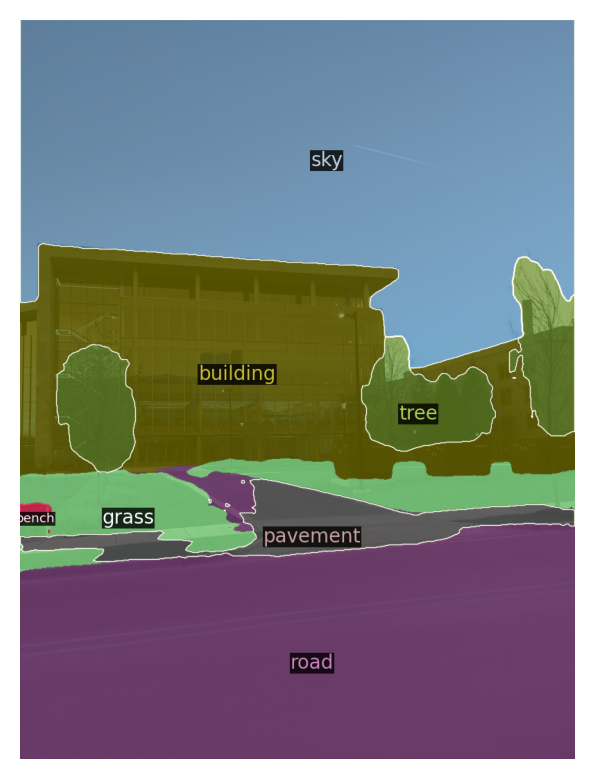

In [22]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
plt.imshow(v.get_image())
plt.axis('off')  # 关闭坐标轴
plt.show()

In [23]:
# 指定保存路径
save_dir = './DETR_result/image2/'
# 如果目录不存在，则创建
os.makedirs(save_dir, exist_ok=True)

# 初始化字典来存储每个类别的掩码
masks_dict = {}
category_names = {}

# 合并相同标签的掩码
for i, mask in enumerate(out["pred_masks"][keep]):
    if i >= len(segments_info):
        print(f"Warning: Skipping index {i} as it exceeds the length of segments_info")
        continue
    
    # 转换为二进制形式
    mask = (mask > 0.5).cpu().numpy().astype(np.uint8) * 255
    category_id = segments_info[i]['category_id']
    isthing = segments_info[i]['isthing']
    category_name = meta.thing_classes[category_id] if isthing else meta.stuff_classes[category_id]
    
    if category_id not in masks_dict:
        masks_dict[category_id] = mask
    else:
        masks_dict[category_id] = np.maximum(masks_dict[category_id], mask)
    
    category_names[category_id] = category_name

# 获取排序后的类别标签
sorted_category_ids = sorted(masks_dict.keys())

# 保存合并后的掩码并输出图片类别文件
image_categories_file = os.path.join(save_dir, 'image_categories.txt')
with open(image_categories_file, 'w') as f:
    for category_id in sorted_category_ids:
        merged_mask = masks_dict[category_id]
        mask_img = Image.fromarray(merged_mask)
        mask_img.save(os.path.join(save_dir, f'mask_class_{category_id}.png'))
        category_name = category_names[category_id]
        f.write(f'Label ID: {category_id}, Category: {category_name}\n')

print(f"Files saved to: {save_dir}")

Files saved to: ./DETR_result/image2/


In [15]:
# Clear folder
import shutil
# Define the folder path you want to delete
folder_to_delete = './DETR_result/image2/'

# Check if the folder exists and delete it
if os.path.exists(folder_to_delete):
    shutil.rmtree(folder_to_delete)
    print(f"Folder '{folder_to_delete}' has been deleted.")
else:
    print(f"Folder '{folder_to_delete}' does not exist.")

Folder './DETR_result/image2/' has been deleted.
